In [1]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from itertools import cycle
import matplotlib.patches as mpatches 
import random
import os

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
from torchvision.models import resnet50, ResNet50_Weights


weights = ResNet50_Weights.DEFAULT
resnet50_model = resnet50(weights=weights)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# Remove the final classification (softmax) layer
model = torch.nn.Sequential(*(list(resnet50_model.children())[:-1])) 
model.eval()
model = model.to(device)

cuda


In [3]:
SUBJECT =1
BATCH_SIZE = 1
learning_rate = 0.01
EPOCHS = 100
SaveModelOnEveryEPOCH = 100
EEG_DATASET_PATH = "./data/eeg/eeg_signals_raw_with_mean_std.pth"

LSTM_INPUT_FEATURES = 2048 # should be image features output.
LSTM_HIDDEN_SIZE = 460  # should be same as sequence length

custom_model_weights =  "./models/raw/FC__subject1_epoch_200.pth"

In [4]:
from utils.CustomModel import CustomModel
CustModel = CustomModel(input_size=(LSTM_INPUT_FEATURES),output_size=(LSTM_HIDDEN_SIZE*128))

if os.path.exists(custom_model_weights):
    CustModel = torch.load(custom_model_weights)
    print(f"loaded custom weights: {custom_model_weights}")

CustModel.to(device)

loaded custom weights: ./models/raw/FC__subject1_epoch_200.pth


CustomModel(
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=2000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2000, out_features=58880, bias=True)
  )
)

In [5]:
# Dataset class
class EEGDataset:
    # Constructor
    def __init__(self, eeg_signals_path, eeg_splits_path, subset='train',subject=1, time_low=40,time_high=500, model_type="cnn", imagesRoot="./data/images/imageNet_images", preprocessin_fn=None):
        # Load EEG signals

        assert subset=='train' or subset=='val' or subset=='test'

        self.time_low = time_low
        self.time_high = time_high
        self.model_type = model_type
        self.imagesRoot = imagesRoot

        splits = torch.load(eeg_splits_path)
        subset_indexes = splits["splits"][0][f"{subset}"]

        loaded = torch.load(eeg_signals_path)

        self.subsetData = []
        self.labels = []
        self.images = []

        class_labels = loaded["labels"]
        image_names = loaded['images']


        for sub_idx in subset_indexes:
            if subject!=0:
                # print(loaded['dataset'][sub_idx]['subject'])
                if loaded['dataset'][sub_idx]['subject']==subject:
                    # print(loaded['dataset'][sub_idx]['subject'])
                    self.subsetData.append(loaded['dataset'][sub_idx])
                    # self.labels.append(class_labels[loaded["dataset"][sub_idx]['label']])
                    self.labels.append(loaded["dataset"][sub_idx]['label'])
                    self.images.append(image_names[loaded["dataset"][sub_idx]['image']])
            else:
                sub_idx = int(sub_idx)
                # print(sub_idx)
                self.subsetData.append(loaded['dataset'][sub_idx])
                # self.labels.append(class_labels[loaded["dataset"][sub_idx]['label']])
                self.labels.append(loaded["dataset"][sub_idx]['label'])
                self.images.append(image_names[loaded["dataset"][sub_idx]['image']])


        # Compute size
        self.size = len(self.subsetData)

        self.preprocessin_fn = None
        if preprocessin_fn is not None:
            self.preprocessin_fn = preprocessin_fn

        self.trans = transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)


    # Get size
    def __len__(self):
        return self.size

    # Get itemsubset
    def __getitem__(self, i):
        # Process EEG
        # eeg = self.data[i]["eeg"].float().t()
        eeg = self.subsetData[i]["eeg"].float().t()
        eeg = eeg[self.time_low:self.time_high,:]

        if self.model_type == "model10":
            eeg = eeg.t()
            eeg = eeg.view(1,128,self.time_high-self.time_low)
        # Get label
        # label = self.data[i]["label"]
        label = self.labels[i]

        folder_name = self.images[i].split("_")[0]
        ImagePath = f"{self.imagesRoot}/{folder_name}/{self.images[i]}.JPEG"


        image = Image.open(ImagePath).convert('RGB')
        # print(type(self.trans))
        # image = self.trans(image)
        if self.preprocessin_fn is not None:
            image = self.preprocessin_fn(image)

        # Return
        return eeg, label, image

In [26]:
# dataset = EEGDataset(subset=subset,eeg_signals_path="./data/eeg/eeg_55_95_std.pth", eeg_splits_path="./data/eeg/block_splits_by_image_all.pth", subject=1,preprocessin_fn=None, time_low=20, time_high=480)
dataset = EEGDataset(subset="train",eeg_signals_path="./data/eeg/eeg_signals_raw_with_mean_std.pth", eeg_splits_path="./data/eeg/block_splits_by_image_all.pth", subject=1,preprocessin_fn=weights.transforms(), time_low=20, time_high=480)
# for subset in ["train","val", "test"]:
#     for sub in [0,1,2,3,4,5,6]:
#         dataset = EEGDataset(subset=subset,eeg_signals_path="./data/eeg/eeg_55_95_std.pth", eeg_splits_path="./data/eeg/block_splits_by_image_all.pth", subject=sub,preprocessin_fn=None, time_low=20, time_high=480)
#         print(f"Subset: {subset}, Subject: {sub} Length:{len(dataset)}")
# dataset = EEGDataset(eeg_signals_path="./data/eeg/eeg_signals_raw_with_mean_std.pth", eeg_splits_path="./data/eeg/block_splits_by_image_all.pth", subject=5,preprocessin_fn=None, time_low=0, time_high=480)

In [27]:
len(dataset)

1320

In [28]:
label_wise_data = {}
for data in dataset:

    eeg, label, image = data

    with torch.no_grad():
        features = model(image.unsqueeze(0).to(device))
        features = features.view(-1, features.size(1))
        outputs = CustModel(features)

    test_eeg = outputs.cpu().numpy() 


    if not label in label_wise_data:
        label_wise_data[label] = {"images":[], "eeg":[]}

    label_wise_data[label]["images"].append(image)

    label_wise_data[label]["eeg"].append(test_eeg)


In [29]:
label_wise_data.keys()

dict_keys([10, 30, 25, 18, 3, 8, 11, 28, 38, 20, 23, 0, 34, 39, 21, 6, 26, 1, 27, 37, 19, 9, 12, 35, 29, 17, 32, 5, 31, 2, 33, 36, 24, 13, 7, 4, 14, 15, 22, 16])

In [46]:
eeg_features = []
eeg_labels = []
# eeg_images = []
for label, labeData in label_wise_data.items():
    eeg_fet = labeData["eeg"]
    for eeg in eeg_fet:
        # if label==25 or label==19:
        eeg_features.append(eeg)
        eeg_labels.append(label)
        # eeg_images.append(labeData["images"])
# for labeData in label_wise_data[0]["eeg"]:
#     eeg_features.append(labeData)
eeg_features  =np.array(eeg_features, dtype=float)

In [32]:
eeg_features.shape

(1320, 1, 58880)

In [33]:
eeg_features = eeg_features.reshape(eeg_features.shape[0], -1)

In [34]:
eeg_features.shape

(1320, 58880)

In [ ]:
lines = []
channel_map = {}
with open("channelmap.txt") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        line = line.strip()
        line = line.split("=")
        SciTerm = line[-1]
        ChanNum = line[0]
        ChanNum = ChanNum.split("-")
        ChanNum_int = int(ChanNum[-1])
        ChanNum = ChanNum[0]
        channel_map[ChanNum_int] = SciTerm

print(channel_map)

selected_channels = []
for channe in range(128):
    if "O" in channel_map[channe+1]:
        # print(channe,channel_map[channe+1])
        selected_channels.append(channe)

selected_channels.remove(27)  # 27 PO9
# selected_channels.remove(28)  # 28 O1
# selected_channels.remove(29)  # 29 Oz
# selected_channels.remove(30)  # 30 O2
selected_channels.remove(31)  # 31 PO10
selected_channels.remove(59)  # 59 PO7
selected_channels.remove(60)  # 60 PO3
selected_channels.remove(61)  # 61 POz
selected_channels.remove(62)  # 62 PO4
selected_channels.remove(63)  # 63 PO8
selected_channels.remove(91)  # 91 POO9h
selected_channels.remove(92)  # 92 POO1
selected_channels.remove(93)  # 93 POO2
selected_channels.remove(94)  # 94 POO10h
selected_channels.remove(117) # 117 PPO9h
selected_channels.remove(118) # 118 PPO5h
selected_channels.remove(119) # 119 PPO1h
selected_channels.remove(120) # 120 PPO2h
selected_channels.remove(121) # 121 PPO6h
selected_channels.remove(122) # 122 PPO10h
selected_channels.remove(125) # 125 OI1h
selected_channels.remove(126) # 126 OI2h

for chn in selected_channels:
    print(f"Channel : {chn}-{channel_map[chn+1]} will be displayed")

In [35]:
eeg_features.shape

(1320, 58880)

In [42]:
import umap
reducer = umap.UMAP(n_components=3)

In [43]:
reducer

UMAP(n_components=3)

In [44]:
embedding = reducer.fit_transform(eeg_features)
embedding.shape
# torch.save(X_tsne_flattned,"tsne_fltattned_raw_data_perplexity_20_init_random_lr_auto.pth")

(1320, 3)

In [45]:
plt.figure().set_size_inches(20,10)
plt.clf()

cmap = plt.cm.get_cmap("hsv", len(label_wise_data.keys()))
gen_colors = []
handles = []
cmaps = []
for eeg_label in list(label_wise_data.keys()):
    _patch = mpatches.Patch(color=cmap(eeg_label), label=f'Class {eeg_label}') 
    cmaps.append(cmap(eeg_label))
    handles.append(_patch)

for i in range(eeg_features.shape[0]):
    colorMap = cmaps[eeg_labels[i]]
    gen_colors.append(colorMap)

<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'UMAP projection of the EEG dataset')

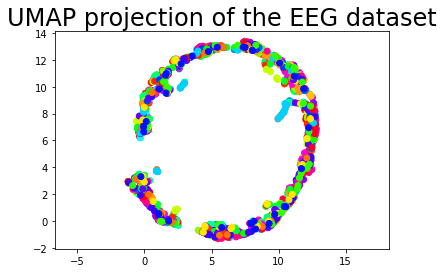

In [40]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=gen_colors)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the EEG dataset', fontsize=24)

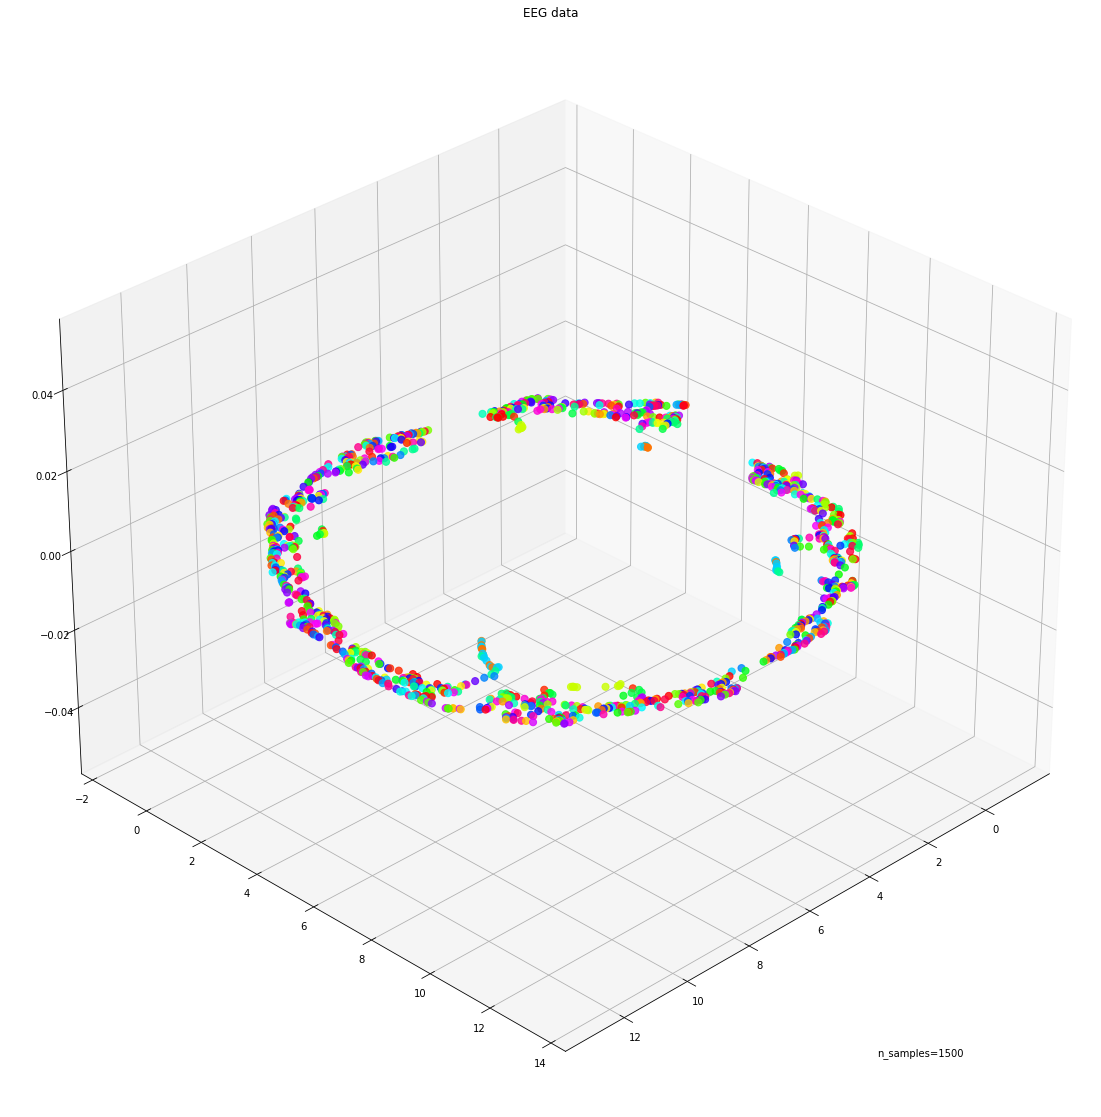

In [41]:
fig = plt.figure(figsize=(20, 20))
fig.set_size_inches(20,20)
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)

ax.set_title("EEG data")
# ax.view_init(azim=90, elev=1)
ax.view_init(azim=45, elev=30)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)

ax.scatter(embedding[:,0], embedding[:,1],embedding[:,2], c=gen_colors, s=50, alpha=0.8)

In [ ]:
eeg_features.shape

In [ ]:
channel_cmaps = []
channel_cmap = plt.cm.get_cmap("hsv", 128)
for chn_range in range(128):
    channel_cmaps.append(channel_cmap(chn_range))

In [ ]:
fig = plt.figure(figsize=(8, 6))
fig.set_size_inches(11,11)
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)

ax.set_title("EEG data")
ax.view_init(azim=-30, elev=50)

eeg_labels_np = np.array(eeg_labels)

c_label = 30
handles = []
for chn_c in range(128):
    
    # print(eeg_labels_np.shape)
    filtered = np.where(eeg_labels_np == c_label)[0]
    filtered_tsne = np.take(tsne_channel_wise[chn_c], filtered, 0)
    # print(filtered_tsne.shape, chn_c)

    _ = ax.text2D(0.8, 0.05, s=f"n_samples={filtered_tsne.shape[0]}", transform=ax.transAxes)

    _patch = mpatches.Patch(color=channel_cmaps[chn_c], label=f'channel {chn_c}') 
    handles.append(_patch)
    ax.scatter(filtered_tsne[:,0], filtered_tsne[:,1],filtered_tsne[:,2], c=[channel_cmaps[chn_c] for i in range(filtered_tsne.shape[0])], s=50, alpha=0.8)



plt.legend(handles=handles, loc="lower left", fontsize=10,ncol=4, bbox_to_anchor=(1.0, 0.0),fancybox=True) 

In [ ]:
plt.figure(figsize=(20, 20))
plt.scatter(X_tsne_flattned[:,0], X_tsne_flattned[:,1], c=gen_colors, alpha=0.5)

In [ ]:
fig = plt.figure(figsize=(20, 20))
fig.set_size_inches(20,20)
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)

ax.set_title("EEG data")
# ax.view_init(azim=90, elev=1)
ax.view_init(azim=90, elev=100)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)

sel_channel = 97
ax.scatter(X_tsne_flattned[:,0], X_tsne_flattned[:,1], c=gen_colors, s=50, alpha=0.8)

In [ ]:
eeg_labels_np = np.array(eeg_labels)
print(eeg_labels_np.shape)

In [ ]:
filtered = np.where(eeg_labels_np == 0)[0]

In [ ]:
filtered.shape

In [ ]:
np.take(tsne_channel_wise[0], filtered, 0).shape

In [ ]:
# for label_idx, c_label in enumerate(list(set(eeg_labels))):
c_label = 0
for chn in range(128):
    fig = plt.figure(figsize=(20, 20))
    fig.set_size_inches(20,20)
    ax = fig.add_subplot(111, projection="3d")
    fig.add_axes(ax)

    ax.set_title("EEG data")
    ax.view_init(azim=-50, elev=50)
    _ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)

    handles.append(mpatches.Patch(color=channel_cmaps[int(random.random()*128)], label=f'Channel {chn}') )
    plt.legend(handles=handles, loc="lower right", fontsize=10,ncol=4, bbox_to_anchor=(1.0, 0.0),fancybox=True) 

    # filtered = np.where(eeg_labels_np == c_label)[0]
    # filtered_tsne = np.take(tsne_channel_wise[chn], filtered, 0)
    # ax.scatter(filtered_tsne[:,0], filtered_tsne[:,1], c=[cmaps[c_label] for i in range(filtered_tsne.shape[0])], s=50, alpha=0.8)
    ax.scatter(tsne_channel_wise[chn][:,0], tsne_channel_wise[chn][:,1],tsne_channel_wise[chn][:,2], c=gen_colors, s=50, alpha=0.8)
    
    fig.savefig(f"output/{c_label}_raw_eeg_channel_{chn}.png")
    fig.clf()

    del handles[-1]

In [ ]:
# # EEG flattened features fit.
# X_tsne = TSNE(n_components=3,perplexity=50, init="pca", learning_rate='auto').fit_transform(eeg_features)

In [ ]:
len(handles)

In [ ]:
X_tsne.shape

In [ ]:
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gen_colors,cmap=plt.get_cmap("Spectral"),alpha=.4,edgecolor='k',projection="3d")

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=gen_colors, s=50, alpha=0.8
)
ax.set_title("EEG data")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)


In [ ]:
X_tsne.shape

In [ ]:
X_tsne.shape

In [ ]:
SELECTED_SAMPLE = 0
SELECTED_CLASS = 13
SELECTED_CHANNEL = 1
TIME_SERIES_START = 0
TIEM_SERIES_END = 500

SELECTED_CLASSES = [2,13,19,25,30]


colorMapString = {}

for SELECTED_CLASS in SELECTED_CLASSES:

    label0data = np.array(label_wise_data[SELECTED_CLASS]["eeg"])
    cmap = plt.cm.get_cmap("tab20", label0data.shape[0])

    for sample_num in range(10):

        plt.figure().set_size_inches(20,10)
        plt.clf()
        f, axarr = plt.subplots(1,2)
        f.set_size_inches(20,10)

        handles = []
        
        SELECTED_SAMPLE = sample_num

        image = label_wise_data[SELECTED_CLASS]["images"][SELECTED_SAMPLE]
        for channe_num in selected_channels:
            rand_int = random.randint(0, label0data.shape[0])
            colorMap = cmap(rand_int)
            if not channel_map[channe_num+1] in colorMapString:
                colorMapString[channel_map[channe_num+1]] = colorMap

            colorMap = colorMapString[channel_map[channe_num+1]]

            axarr[1].plot(label0data[SELECTED_SAMPLE][TIME_SERIES_START:TIEM_SERIES_END,channe_num], c=colorMap)
            max_of_channel  =np.max(label0data[SELECTED_SAMPLE][TIME_SERIES_START:TIEM_SERIES_END,channe_num])
            max_of_channel = str(np.round(max_of_channel,2))
            min_of_channel  = np.min(label0data[SELECTED_SAMPLE][TIME_SERIES_START:TIEM_SERIES_END,channe_num])
            min_of_channel = str(np.round(min_of_channel,2))
            _channel_patch = mpatches.Patch(color=colorMap, label=f'Channel: {channe_num}:{channel_map[channe_num+1]} [{min_of_channel}:{max_of_channel}]')
            handles.append(_channel_patch)

        rand_int = random.randint(1, label0data.shape[0])
        _sample_patch = mpatches.Patch(color=cmap(rand_int), label=f'Sample: {SELECTED_SAMPLE}')
        handles.append(_sample_patch)

        if not f"class_{SELECTED_CLASS}" in colorMapString:
            rand_int = random.randint(1, label0data.shape[0])
            colorMap = cmap(rand_int)
            colorMapString[f"class_{SELECTED_CLASS}"] = colorMap

        _class_patch = mpatches.Patch(color=colorMapString[f"class_{SELECTED_CLASS}"], label=f"CLASS: {SELECTED_CLASS}")
        handles.append(_class_patch)

        if not "TS" in colorMapString:
            rand_int = random.randint(1, label0data.shape[0])
            colorMap = cmap(rand_int)
            colorMapString["TS"] = colorMap

        TS_patch = mpatches.Patch(color=colorMapString["TS"],label=f"T: {TIME_SERIES_START}:{TIEM_SERIES_END}") 
        handles.append(TS_patch)

        axarr[1].legend(handles=handles, loc="lower right", fontsize=13, bbox_to_anchor=(1.0, 0.0),fancybox=True,ncol=1)
        axarr[0].imshow(image)
        f.savefig(f"./output/Class_{SELECTED_CLASS}_Sample_{SELECTED_SAMPLE}_Channels_{selected_channels}.png")